## Multi-label Legal Text Classification for CIA

### *Document layout detection*
https://towardsdatascience.com/analyzing-document-layout-with-layoutparser-ed24d85f1d44

In [ ]:
!pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
!pip install pdf2image
!pip install "layoutparser[ocr]"

In [25]:
import pdf2image
from pdf2image import convert_from_bytes, convert_from_path
import numpy as np
import pandas as pd
import os
from glob import glob
import layoutparser as lp

In [4]:
os.chdir("../..")
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Thesis/multilabel-legal-text-classification-CIA'

Create list of paths for PDFs

In [309]:
dir = "data/legislation/Philippines/"
pdf_list = glob(os.path.join(dir, "*.pdf"))
len(pdf_list)

20

Read all PDF files as images, convert image to arrays and save in a list. 

In [310]:
img_list = []
for pdf in pdf_list:
    # convert pdf to image
    file = convert_from_path(pdf)
    # read image as array
    for (i, page) in enumerate(file):
        img = np.asarray(file[i])
    # append to list 
        img_list.append(img)
    print('{} is done'.format(pdf) + ': ' + str(len(file)) + ' pages')

data/legislation/Philippines/PH_RA 9337 Amendments to Internal Revenue Code 2005.pdf is done: 52 pages
data/legislation/Philippines/PH_RA 7354 Postal Service Act 1992.pdf is done: 15 pages
data/legislation/Philippines/PH_EO 292 Administrative Code 1987.pdf is done: 345 pages
data/legislation/Philippines/PH_RA 7160 Local Government Code 1991.pdf is done: 325 pages
data/legislation/Philippines/PH_RA 11232 Revised Corporation Code 2019.pdf is done: 73 pages
data/legislation/Philippines/PH_CA 146 Public Service Act 1936.pdf is done: 15 pages
data/legislation/Philippines/PH_RA 4136 Land Transportation Act 1964.pdf is done: 44 pages
data/legislation/Philippines/PH_EO 24 2011.pdf is done: 13 pages
data/legislation/Philippines/PH_RA 9184 Government Procurement Act IRR 2016.pdf is done: 149 pages
data/legislation/Philippines/PH_EO 203.pdf is done: 6 pages
data/legislation/Philippines/PH_RA 11032 EODB 2017.pdf is done: 13 pages
data/legislation/Philippines/PH_EO 80 2012.pdf is done: 8 pages
data

In [311]:
len(img_list)

1217

Document layout recognition \
https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html#model-catalog

In [312]:
# model used for DLA
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.45], # if confidence score < 0.5, bounding box will not appear 
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [313]:
layout_results = []
for img in img_list:
    layout = model.detect(img)
    layout_results.append(layout)

In [248]:
len(layout_results)

425

In [251]:
layout_results[300]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=221.63812255859375, y_1=110.68356323242188, x_2=1195.858154296875, y_2=1370.8792724609375), text=None, id=None, type=List, parent=None, next=None, score=0.9715340733528137), TextBlock(block=Rectangle(x_1=293.32733154296875, y_1=191.8548583984375, x_2=1174.4559326171875, y_2=272.1846618652344), text=None, id=None, type=Title, parent=None, next=None, score=0.9300223588943481), TextBlock(block=Rectangle(x_1=325.795654296875, y_1=1852.019775390625, x_2=1020.9579467773438, y_2=1888.4638671875), text=None, id=None, type=Text, parent=None, next=None, score=0.8306819796562195), TextBlock(block=Rectangle(x_1=246.4893035888672, y_1=1606.173583984375, x_2=1184.1307373046875, y_2=1788.097900390625), text=None, id=None, type=Title, parent=None, next=None, score=0.8163231611251831), TextBlock(block=Rectangle(x_1=905.9815673828125, y_1=1326.792236328125, x_2=1170.880615234375, y_2=1356.18212890625), text=None, id=None, type=Text, parent=None, next=None, s

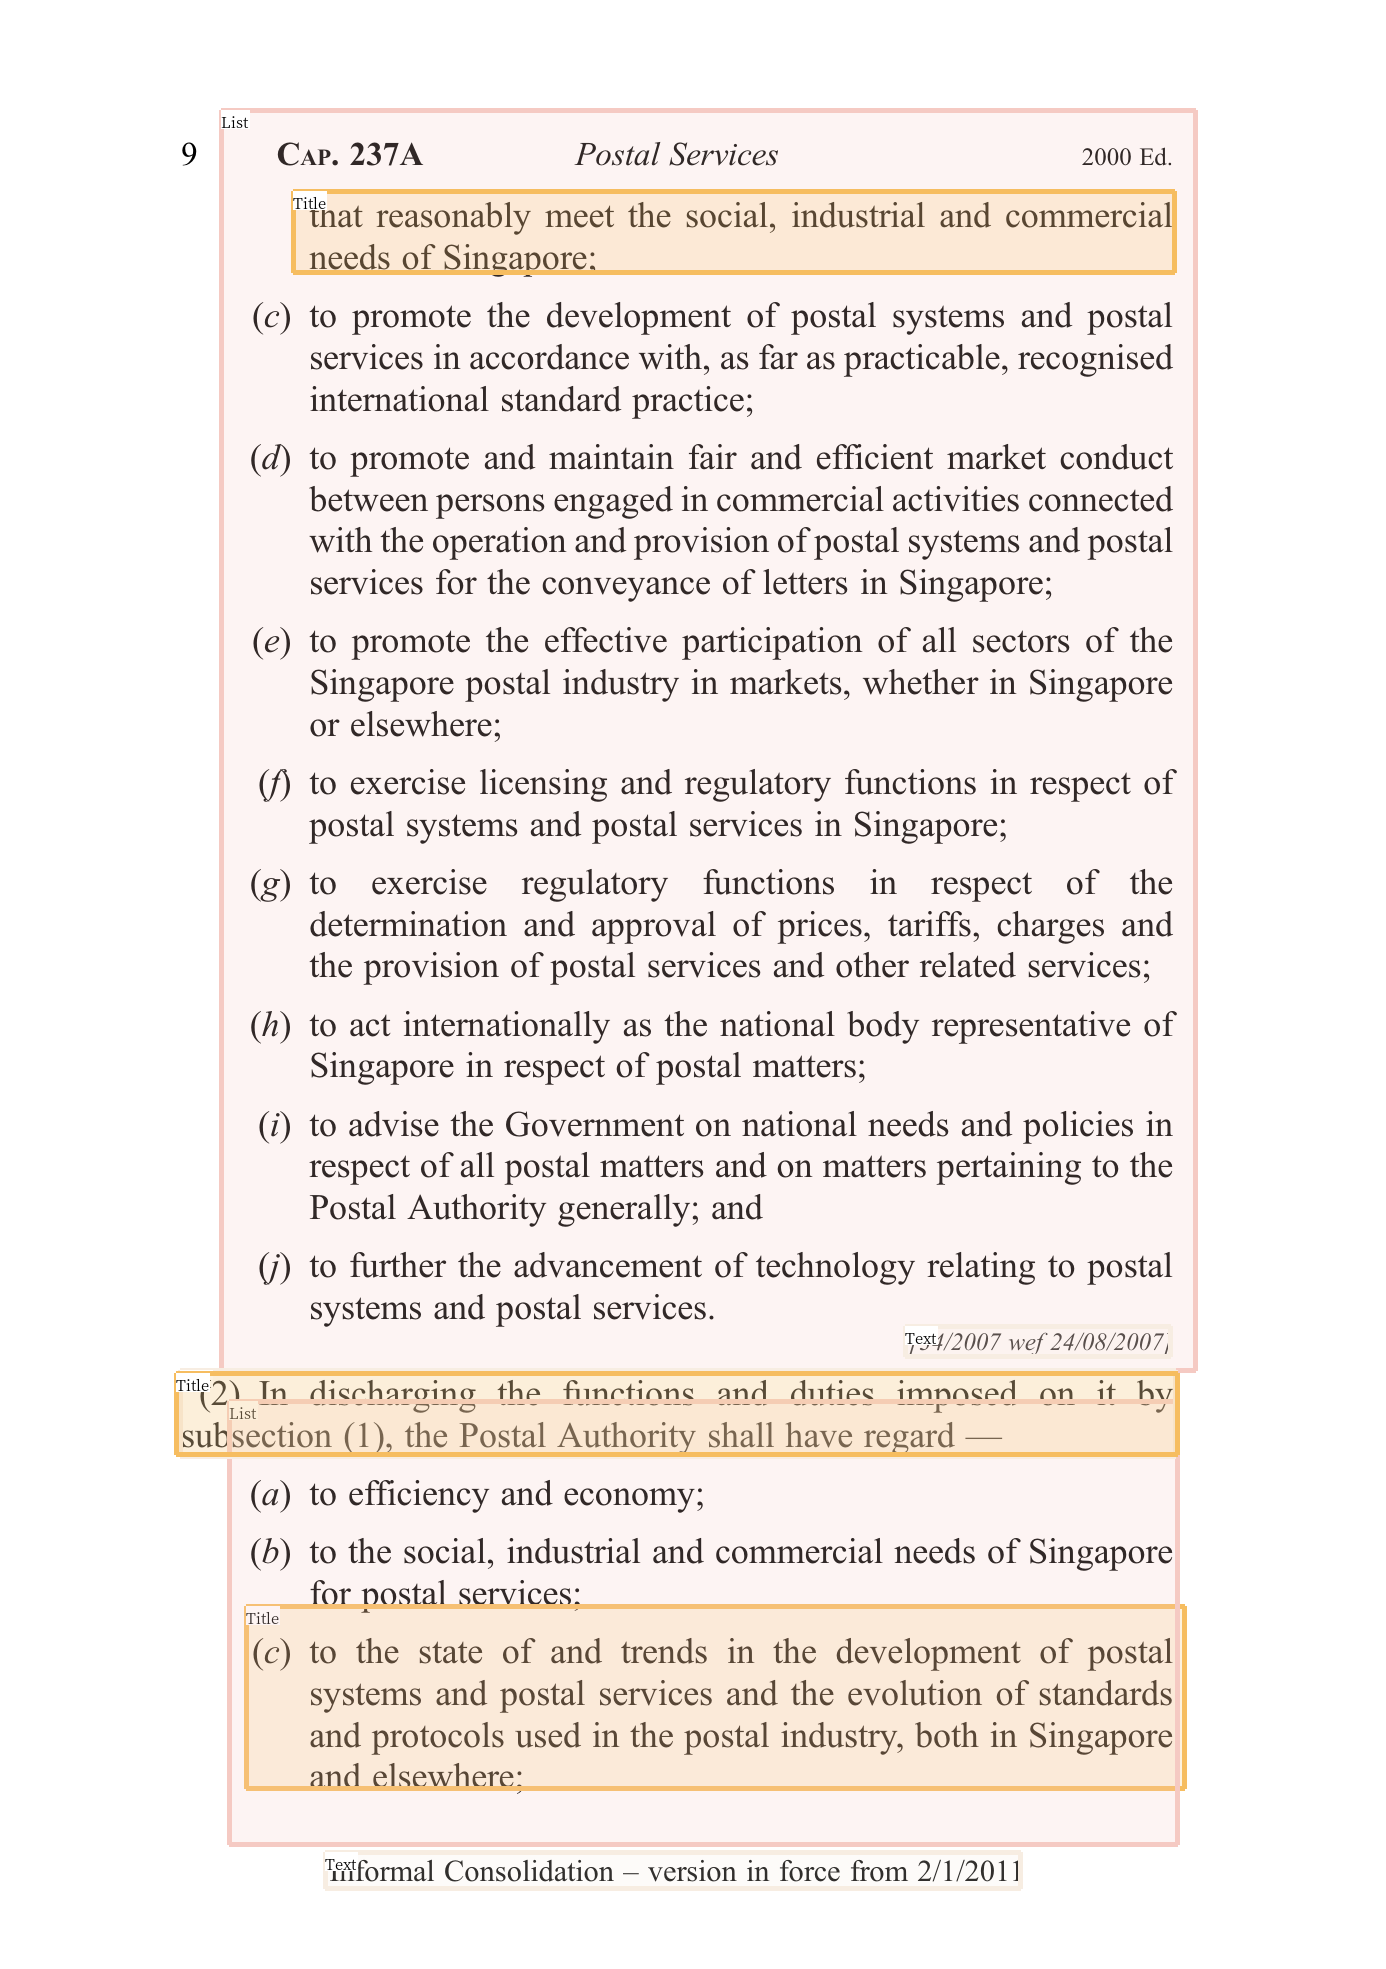

In [252]:
lp.draw_box(img_list[300], layout_results[300],  box_width=5, box_alpha=0.2, show_element_type=True)

In [253]:
texts = []
for result in layout_results:
    text = lp.Layout([b for b in result if b.type=='Text' or b.type == 'List']) 
    texts.append(text)

In [254]:
len(texts)

425

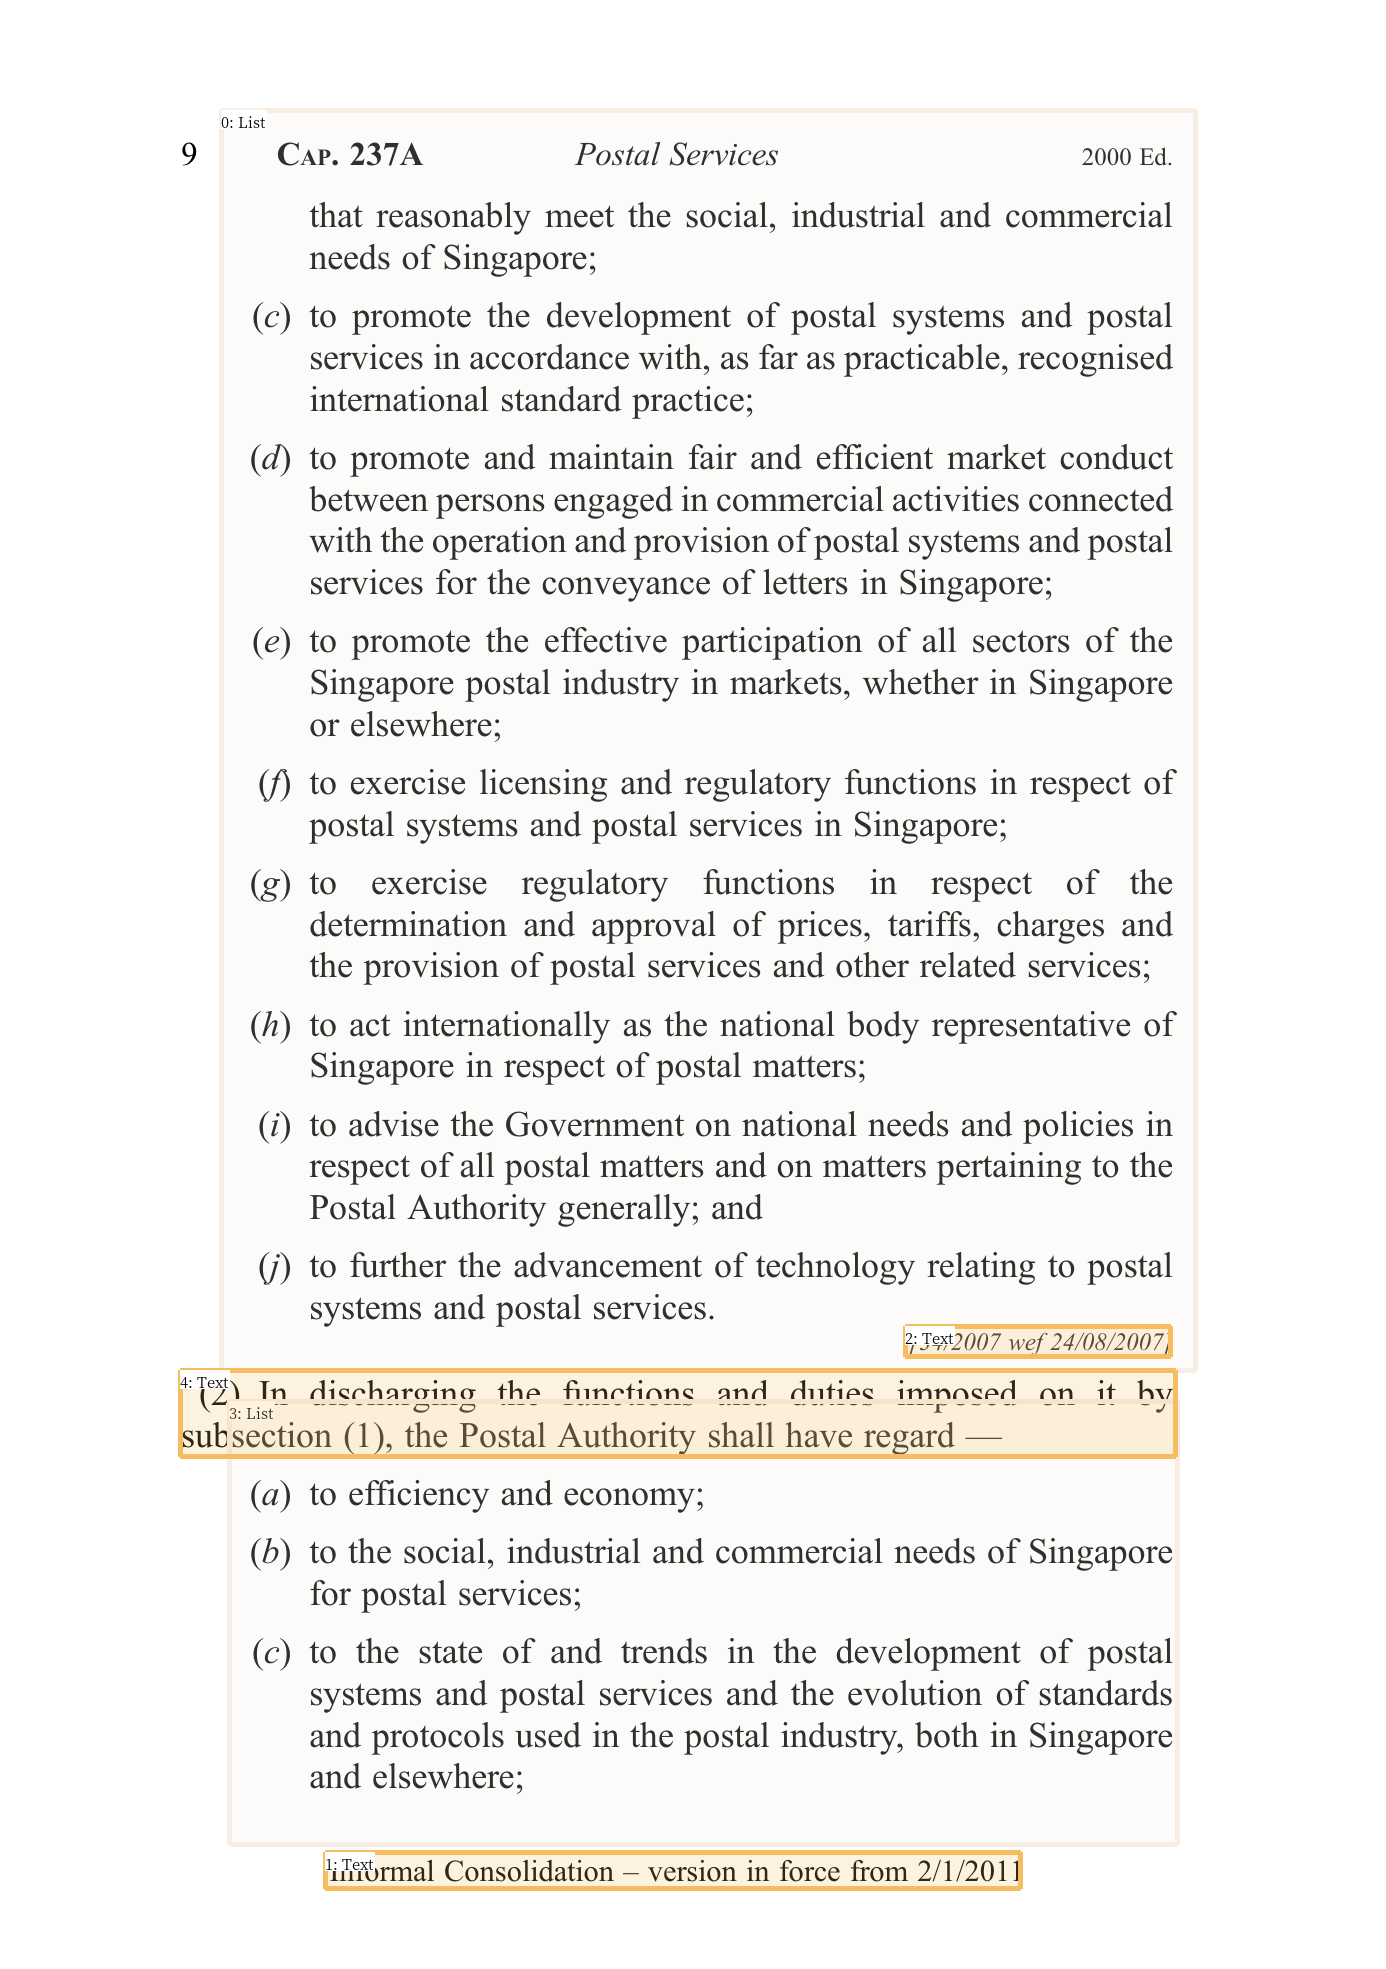

In [256]:
lp.draw_box(img_list[300], texts[300],  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)


In [263]:
img = img_list[300]

In [275]:
ocr_agent = lp.TesseractAgent(languages='eng')

In [287]:
ocr_text = []
for item, img in zip(texts, img_list): 
    for block in item:
        # crop image around the detected layout
        segment_image = (block
                        .pad(left=15, right=15, top=5, bottom=5)
                        .crop_image(img))
        # perform OCR
        text = ocr_agent.detect(segment_image)
        # save OCR result
        block.set(text=text, inplace=True)
    ocr_text.append(item)

In [288]:
len(ocr_text)

425

In [303]:
final_texts = []
for file in ocr_text:
    for text in file:
        final_texts.append(text.text)

In [308]:
final_texts[100]

'This Code distinguishes between Licensees that are subject to competitive\n'